# Imputation Comparison

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_imputation_comparison.ipynb)

This notebook explains how the `ImputationSelector` class works in `probatus`. With `ImputationSelector` you can compare multiple imputation strategies
and choose a strategy which works the best for a given model and a dataset.
Currently `ImputationSelector` supports any scikit learn compatible imputation strategy. For categorical variables the missing values are replaced by `missing` token and `OneHotEncoder` is applied. The user supplied imputation strategies are applied to numerical columns only. 
Support for user supplied imputation strategies for categorical columns can be added in the future releases.

Let us look at an example and start by importing all the required classes and methods.



In [52]:
###Install the packages 
#%%capture
#!pip install probatus
#!pip install lightgbm

In [53]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)
from probatus.missing_values.imputation import ImputationSelector
from probatus.utils.missing_helpers import generate_MCAR
import lightgbm as lgb 
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer,SimpleImputer,IterativeImputer
from sklearn.datasets import make_classification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let us create a classification dataset to apply the various imputation strategies.

Add missing values to the dataset. `generate_MCAR` method randomly adds missing values to the dataset.

In [54]:
n_features = 20
X,y = make_classification(n_samples=2000,n_features=n_features,random_state=123,class_sep=0.3)
X = pd.DataFrame(X, columns=["f_"+str(i) for i in range(0,n_features)])
print(f"Shape of X,y : {X.shape},{y.shape}")

Shape of X,y : (2000, 20),(2000,)


In [55]:
X_missing = generate_MCAR(X,missing=0.2)
missing_stats = pd.DataFrame(X_missing.isnull().mean()).T
missing_stats.index=['Missing %']
missing_stats

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19
Missing %,0.189,0.1975,0.1965,0.2095,0.1895,0.1955,0.202,0.198,0.2015,0.1885,0.199,0.208,0.2055,0.21,0.2045,0.2005,0.209,0.2,0.2135,0.186


The data has approximately 20% missing values in each feature.

## Imputation Strategies

Create a dictionary with all the strategies to compare. Also, create a classifier to use for evaluating various strategies.
If the model supports handling of missing features by default then the model performance on an unimputed dataset is calculated. You can indicate that the model supports handling missing values by setting the parameter `model_na_support=True`.
The model performance against the unimputed dataset can be found in `No Imputation` results.

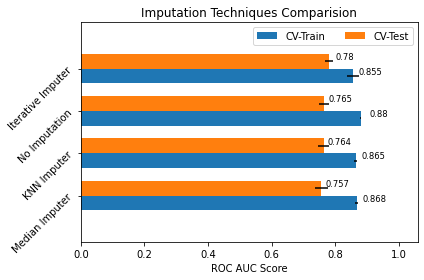

In [56]:
strategies = {
    'KNN Imputer' : KNNImputer(n_neighbors=3),
    'Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,sample_posterior=True)
    }
    
clf = lgb.LGBMClassifier(n_estimators=2)
cmp = ImputationSelector(clf=clf,strategies=strategies,cv=5,random_state=45,model_na_support=True)
cmp.fit_compute(X_missing,y)
result_plot = cmp.plot()

However if the model does not support missing values by default e.g LogisticRegression , results for only the inputation strategies are calculated. 


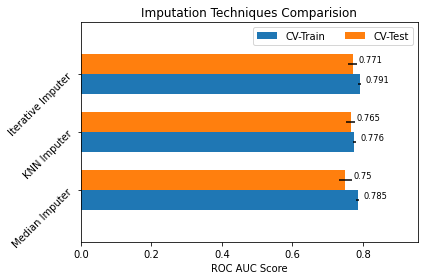

In [57]:

clf = LogisticRegression()
cmp = ImputationSelector(clf=clf,strategies=strategies,cv=5)
cmp.fit_compute(X_missing,y)
result_plot=cmp.plot()

You can also pass a sklearn pipline instead of a classifier.

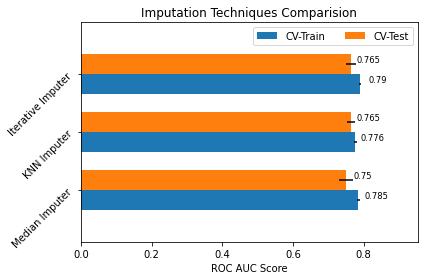

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
steps = [('scaler', StandardScaler()), ('LR', LogisticRegression())]
clf = Pipeline(steps)
cmp = ImputationSelector(clf=clf,strategies=strategies,cv=5,model_na_support=False)
cmp.fit_compute(X_missing,y)
result_plot=cmp.plot()


### Scikit Learn Compatible Imputers. 

You can also use any other scikit-learn compatible imputer as an imputing strategy.
eg. [feature engine](https://feature-engine.readthedocs.io/en/latest/index.html) library provides a host of other imputing stratgies as well. You can pass them for comparision as well.